In [105]:
from mt_scores import get_scores_auto
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random as rand

In [166]:
# This is a notebook to examine errors in the selection process of our efficient lattice with CQEUT
# We'll look at a couple of examples specifically to get our insights
def get_pickle(fname):
    f = open(fname, 'rb')
    return pickle.load(f)

# Load in necessary data for a given graph
def init_data(lang, chosen):
    gbase = "detest_reversed/"
    lpbase = "germanlatpreds"
    expldir = "germantest_exploded/"
    if lang=='fr-en':
        gbase = "frtest_reversed/"
        lpbase = "frenchlatpreds"
        expldir = "frenchtest_exploded/"
        
    graph = get_pickle(gbase+str(chosen))
    lpredsall = pd.read_csv(lpbase)
    # tuple in the format of scores, cands, ref, source
    explvals = get_pickle(expldir+str(chosen))
    # TODO this is probably wrong
    return graph, lpredsall.loc[chosen], explvals

CHOSEN = 0
LANG = "fr-en"

# Get all the appropriate scores based on the data that we got
def generate_scores(lang, chosen):
    g, lp, explode = init_data(lang, chosen)
    # get inputs to pass into stuff, last index is one selected by lattice
    hyps = explode[1]+[lp['ahyp']]
    refs = [explode[2]]*len(hyps)
    srcs = [explode[3]]*len(hyps)
    if lang=="fr-en":
        mname = "./torchsaved/maskedcont4.pt"
    cqeut = get_scores_auto(hyps, srcs, refs, "cqeut", mname)
    cqe = get_scores_auto(hyps, srcs, refs, "cqe", "")
    posthoc = get_scores_auto(hyps, srcs, refs, "posthoc", lang)
    comet = get_scores_auto(hyps, srcs, refs, "comet", "")
    return hyps, cqe, posthoc, comet, cqeut

# Get all the appropriate scores based on the data that we got
def genmany(lang):
    ahyps, arefs, asrcs = [], [], []
    ind = 0
    lens = []
    while ind<76:
        try:
            g, lp, explode = init_data(lang, ind)
            # get inputs to pass into stuff, last index is one selected by lattice
            hyps = explode[1]+[lp['ahyp']]
            refs = [explode[2]]*len(hyps)
            srcs = [explode[3]]*len(hyps)
            lens.append(len(hyps))
            ahyps.extend(hyps)
            arefs.extend(refs)
            asrcs.extend(srcs)
            ind+=1
        except:
            continue
    if lang=="fr-en":
        mname = "./torchsaved/maskedcont4.pt"
    cqeut = get_scores_auto(ahyps, asrcs, arefs, "cqeut", mname)
    with open('bigcqeut.pickle', 'wb') as handle:
        pickle.dump(cqeut, handle)
    cqe = get_scores_auto(ahyps, asrcs, arefs, "cqe", "")
    with open('bigcqe.pickle', 'wb') as handle:
        pickle.dump(cqe, handle)
    posthoc = get_scores_auto(ahyps, asrcs, arefs, "posthoc", lang)
    with open('bigposthoc.pickle', 'wb') as handle:
        pickle.dump(posthoc, handle)
    comet = get_scores_auto(ahyps, asrcs, arefs, "comet", "")
    with open('bigcomet.pickle', 'wb') as handle:
        pickle.dump(comet, handle)
    return ahyps, cqe, posthoc, comet, cqeut, lens

# get a specific ind from all the generated stuff
def extract_bg_ind(bgres, ind, asdict=True):
    ahyps, cqe, posthoc, comet, cqeut, lens = bigres
    sind = sum(lens[:ind])
    end = sind+lens[ind]
    # TODO watch out this is kind of hardcoded
    lp = lpredsall.loc[ind]
    # consolidate as a dict
    if asdict:
        res = {
            "hyps": ahyps[sind:end],
            "cqe": cqe[sind:end],
            "posthoc": posthoc[sind:end],
            "comet": comet[sind:end],
            "cqeut": cqeut[sind:end],
            "src": lp["src"],
            "ref": lp["ref"]
        }
        return res
    return ahyps[sind:end], cqe[sind:end], posthoc[sind:end], comet[sind:end], cqeut[sind:end]

# Compare what's selected by the algorithm vs what exploded paths have
# TODO add in params
# we can visualize where lattice is vs distrib of actual stuff, should run 
# whole pipeline for an entire lattice / generate stuff
def compare_latselect(bgres, ind, terms):
    lat = extract_bg_ind(bgres, ind)
    res = {}
    for t in terms:
        res[t+"mean"] = sum(lat[t])/len(lat[t])
        res[t+"select"] = lat[t][-1]
        res[t+"max"] = max(lat[t])
        res[t+"random"] = rand.choice(lat[t])
    return res

def rercompare(bgres, ind, terms):
    lat = extract_bg_ind(bgres, ind)
    res = {}
    for t in terms:
        ind = lat[t].index(max(lat[t]))
        if t=='posthoc':
            ind = lat[t].index(min(lat[t]))
        res[t+"rerank"] = lat["comet"][ind]
        res[t+"cand"] = lat["hyps"][ind]
    res["effcand"] = lat["hyps"][-1]
    return res

def getrer_scatter(bgres, terms, xterm, yterm, lfilter=None):
    allens = len(bgres[-1])
    xres = []
    yres = []
    for a in range(0, allens):
        if lfilter:
            # function to ignore lengths that meet certain conditions
            if lfilter(bgres[-1][a]):
                continue
        lstats = rercompare(bgres, a, terms)
        xres.append(lstats[xterm])
        yres.append(lstats[yterm])
    return xres, yres

def getcomp_scatter(bgres, terms, xterm, yterm, lfilter=None):
    allens = len(bgres[-1])
    xres = []
    yres = []
    for a in range(0, allens):
        if lfilter:
            # function to ignore lengths that meet certain conditions
            if lfilter(bgres[-1][a]):
                continue
        lstats = compare_latselect(bgres, a, terms)
        xres.append(lstats[xterm])
        yres.append(lstats[yterm])
    return xres, yres

# TODO try above pipeline on like 50 lattices, get the data / vis for each of those
# Answer questions or expand analysis
lpredsall = pd.read_csv("frenchlatpreds")

In [172]:
utbest, qebest = getrer_scatter(bigres, ["cqeut", "cqe"], "cqeutrerank", "cqererank")
utbest, bbest = getrer_scatter(bigres, ["cqeut", "cqe", "comet"], "cqeutrerank", "cometrerank")

In [171]:
utcands, effcands = getrer_scatter(bigres, ["cqeut", "cqe"], "cqeutcand", "effcand")

In [179]:
def printdiff(ind, utc, effc):
    print(utc[ind])
    print(effc[ind])

printdiff(2, utcands, effcands)

Another variable is the degree to which other developed countries’ monetary policies will ease.
 The other variable is the extent to which other developed countries will ease their monetary policies.


In [140]:
# leaves only if len less than 1000
def under1000(lenval):
    #print(lenval)
    return lenval>1000

# leaves only if len ge than 1000
def over1000(lenval):
    return lenval<=1000

In [162]:
filt = over1000
means, selected = getcomp_scatter(bigres, ["cqeut"], "cqeutmean", "cqeutselect", filt)
means, randlist = getcomp_scatter(bigres, ["cqeut"], "cqeutmean", "cqeutrandom", filt)
means, maxes = getcomp_scatter(bigres, ["cqeut"], "cqeutmean", "cqeutmax", filt)
diffs = [maxes[i]-selected[i] for i in range(len(maxes))]
rdiffs = [maxes[i]-randlist[i] for i in range(len(maxes))]

(array([ 9., 13., 10.,  4.,  3.,  4.,  0.,  0.,  1.,  1.]),
 array([0.01778781, 0.08811022, 0.15843263, 0.22875503, 0.29907744,
        0.36939985, 0.43972225, 0.51004466, 0.58036706, 0.65068947,
        0.72101188]),
 <BarContainer object of 10 artists>)

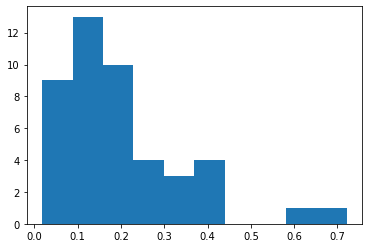

In [163]:
plt.hist(diffs)

In [164]:
print(sum(rdiffs)/len(rdiffs))
print(sum(diffs)/len(diffs))

0.21618366175227696
0.19947809444533454


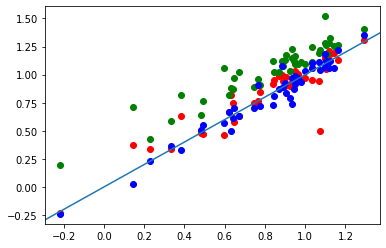

In [136]:
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1)
ax.scatter(means, selected, color='r')
ax.scatter(means, maxes, color='g')
ax.scatter(means, randlist, color='b')

In [98]:
sum(utbest)/len(utbest)

0.5750998928652782

In [32]:
lpredsall.loc[0]

Unnamed: 0                                                      0
Unnamed: 0.1                                                    0
src             Après tout, en tant que journaliste d'investig...
hyp             <s> Après tout, en tant que journaliste d'inve...
ref             After all, as a campaigning investigative jour...
ahyp             After all, as an investigative reporter in th...
scos                                                     0.334722
Name: 0, dtype: object

In [ ]:
#hyps, cqe, posthoc, comet, cqeut =  generate_scores("fr-en", 0)

In [6]:
# ahyps, cqe, posthoc, comet, cqeut, lens
# bigres = genmany("fr-en")
# using loaded
with open('bigreslattice.pickle', 'rb') as handle:
    bigres = pickle.load(handle)

In [27]:
latvals1['hyps'][-1]

' As Iran sought to extend its influence and advance its interests, as well as those of its Shi a allies, talks with the Security Council came to be closely linked to its region-wide ambition s.'

In [ ]:
#with open('bigreslattice.pickle', 'wb') as handle:
#    pickle.dump(bigres, handle)

In [12]:
cqeut[-1]

0.6277338862419128